# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          calculate_hot_start_data
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251013-13-59-27 - 13-59-27


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\four_d.txt.
It is known that the shortest distance is 21


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl, distance_array)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda:0


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 3 qubits needed for 4 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    bin_hot_start_list, sdl.hot_start_dist = calculate_hot_start_data(sdl, 
                                                                    distance_array,
                                                                    cost_fn,
                                                                    print_results=True,
                                                                    )
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    my_input, unrepeated_input = set_up_input_no_hot_start(sdl, device)

In [9]:
unrepeated_input.size()

torch.Size([1024, 3])

In [10]:
print(unrepeated_input.size())

torch.Size([1024, 3])


Set up model with gradient required:

In [11]:
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 24 parameters in total, of which 24 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

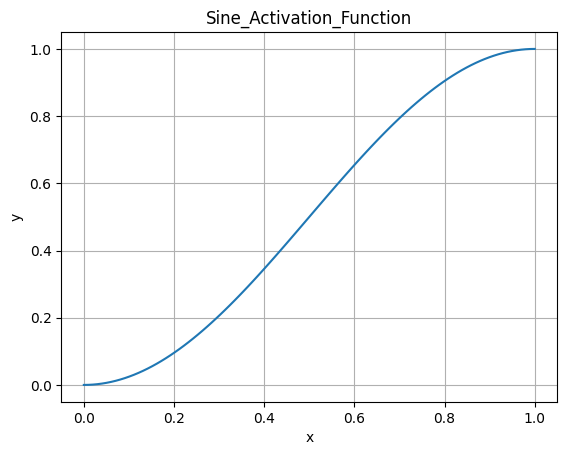

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 0.5672,  0.4903,  0.3043],
        [ 0.1804, -0.0766, -0.0941],
        [ 0.2677,  0.4838, -0.3022]], device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.2331, -0.3157, -0.2326], device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 0.0897,  0.0552,  0.1966],
        [-0.1643,  0.0078,  0.5070],
        [ 0.5769, -0.1068, -0.3804]], device='cuda:0', requires_grad=True), 'fc2.bias': Parameter containing:
tensor([-0.4423, -0.2155, -0.2175], device='cuda:0', requires_grad=True)}


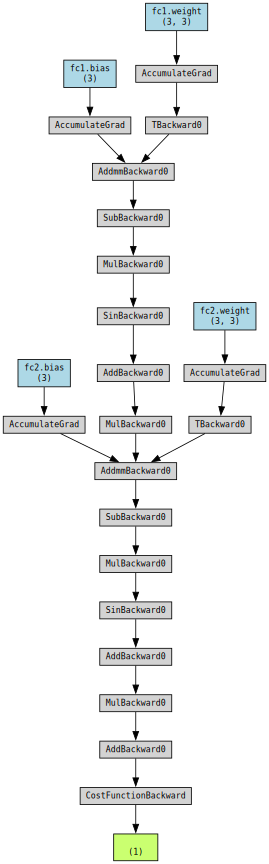

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
"""target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )"""
target, criterion, optimizer = get_ready_to_train(sdl, 
                                                  model,
                                                  #momentum = sdl.momentum,
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 25.000 Epoch min cost:25.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 1.94
Epoch 0, fc2.weight grad: 2.26
Epoch 0, fc2.bias grad: 7.81
Epoch 10, Average cost: 21.000 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 10, fc1.weight grad: 0.00
Epoch 10, fc1.bias grad: 0.00
Epoch 10, fc2.weight grad: 0.00
Epoch 10, fc2.bias grad: 0.00
Epoch 20, Average cost: 21.000 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 20, fc1.weight grad: 0.00
Epoch 20, fc1.bias grad: 1.76
Epoch 20, fc2.weight grad: 1.16
Epoch 20, fc2.bias grad: 2.39
Epoch 30, Average cost: 21.000 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 30, fc1.weight grad: 0.00
Epoch 30, fc1.bias grad: 0.72
Epoch 30, fc2.weight grad: 0.60
Epoch 30, fc2.bias grad: 1.35
Epoch 40, Average cost: 21.000 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 40, fc1.weight grad: 0.00
Epoch 40, fc1.bias grad: 0.50
Epoch 40, fc2.weight grad: 0.25
Epoch

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 21.000 at epoch 0.
The best known cost is 21.000


Plot loss ratio by epoch:

Graph for Run ID: 20251013-13-59-27-13-59-27 being saved to graphs\20251013-13-59-27\13-59-27.png


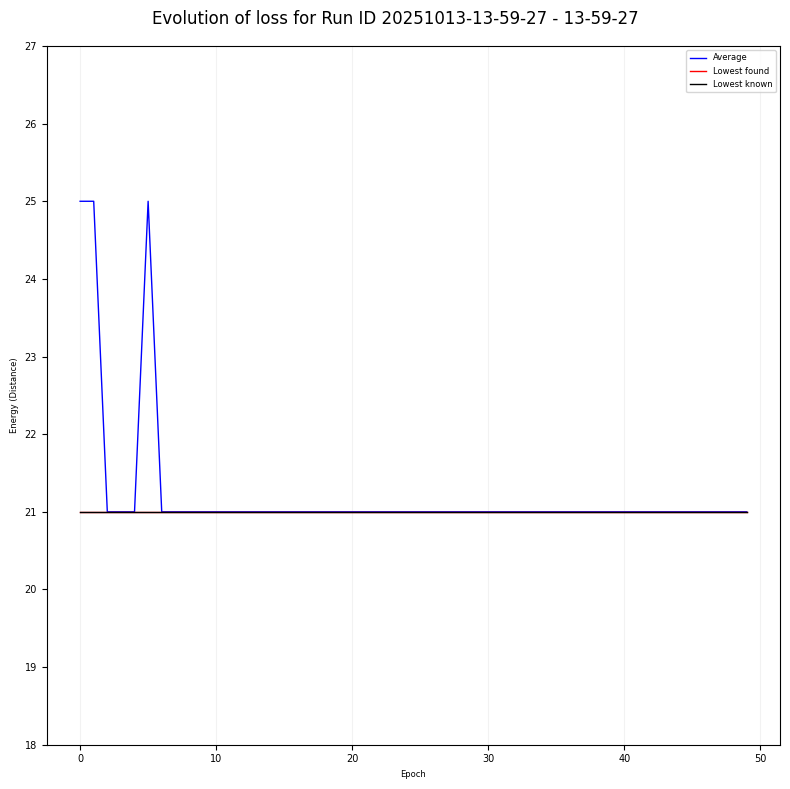

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 0.5670,  0.4902,  0.3042],
        [ 0.1804, -0.0766, -0.0941],
        [ 0.2676,  0.4837, -0.3021]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([ 0.1735, -0.3413, -0.3653], device='cuda:0', requires_grad=True)
weight: Parameter containing:
tensor([[ 0.1330,  0.1203,  0.2067],
        [-0.1563,  0.0225,  0.5099],
        [ 0.5611, -0.1359, -0.3977]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([-0.1243, -0.1464, -0.3431], device='cuda:0', requires_grad=True)
